
### Created on Fri Jun 22th 2020

### @author: Maximilian Forstenhaeusler

# AFM - Contact Mode Example using the afmsim library

### Description 
This is an example of how the library afmsim can be implimeted to simulate an AFM contact mode.  

### Call libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from matplotlib import cm
from afmsim import contact_mode_gen, differential_constants
from numba import jit
from joblib import dump

__________________________________________________________________________________________________________________
### Input parameteres
#### Cantilever and tip parameters

In [2]:
vb = 1000e-9  # velocity of approaching sample
zb = 20e-9  # initial position of cantilever
Q1 = 100  # Quality Factor
k_m1 = 0.1  # equilibrium cantilever mass
fo1 = 10e3  # natural frequency
period1 = 1.0 / fo1  # fundamental period
R = 20e-9  # radius tip
nu = 0.5  # poissons ratio of material

#### Molecular Interaction Forces - Constants

In [3]:
vdw = 2  # vdw constant

#### Simulation Time

In [4]:
start = 0  # defines start of the simulation
landingtime = zb / vb
final_time = 1  # indentation time
stop = landingtime + final_time  # defines end of the simulation
timestep =  period1 / 1.0e4
printstep = period1 / 10  # printstep of Force distance curve

time = np.arange(start, stop, timestep) # time array 

#### Viscelastic Model Parameter 

In [5]:
arms = [3, 5]
Jg = 2.0e-10  # Glassy compliance
J_3 = np.zeros(arms[0])  # compliance array - 3 arm
tau_3 = np.zeros(arms[0])  # characteristic time array - 3 arm
J_5 = np.zeros(arms[1])  # compliance array - 5 arm
tau_5 = np.zeros(arms[1])  # characteristic time array - 5 arm

J_3[0], tau_3[0] = 5.0e-9, 0.5e-4
J_3[1], tau_3[1] = 7.0e-9, 0.5e-3
J_3[2], tau_3[2] = 1.0e-10, 0.5e-2

J_5[0], tau_5[0] = 5.0e-9, 0.5e-4
J_5[1], tau_5[1] = 7.0e-9, 0.5e-3
J_5[2], tau_5[2] = 1.0e-10, 0.5e-2
J_5[3], tau_5[3] = 3.0e-6, 0.5e-1
J_5[4], tau_5[4] = 4.0e-6, 0.5e-0

__________________________________________________________________________________________________________________

### Simulation 

#### Calculation of differential constants used for tip-sample force calculation in AFM simulation

In [6]:
u_3, q_3 = differential_constants('Gen. Kelvin-Voigt', Jg, J_3, tau_3)  # 3 Arm
u_5, q_5 = differential_constants('Gen. Kelvin-Voigt', Jg, J_5, tau_5)  # 5 Arm


#### AFM - Contact Mode simulation (SFS)

In [7]:
AFM_jit = jit()(contact_mode_gen)  # calls AFM simul function and initializes numba procedure to increase iter. speed

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
print('Timestep 1:', timestep)
t0 = tm.time()
Fts_3, tip_3, base_3 = AFM_jit(time, timestep, zb, vb, u_3, q_3, k_m1, fo1, Q1, vdw, R, nu)
t1 = tm.time()
print(' - - - 3 Arm - %s: - - - ' %timestep)
print('Total simulation time: %2.3f' % (t1 - t0))


t2 = tm.time()
Fts_5, tip_5, base_5 = AFM_jit(time, timestep, zb, vb, u_5, q_5, k_m1, fo1, Q1, vdw, R)
t3 = tm.time()
print(' - - - 3 Arm - %s: - - - ' %timestep)
print('Total simulation time: %2.3f' % (t3 - t2))


Timestep 1: 1e-08
 - - - 3 Arm - 1e-08: - - - 
Total simulation time: 89.743
 - - - 3 Arm - 1e-08: - - - 
Total simulation time: 112.730


#### Storing the data 

In [11]:
print('\nstoring data...')
# initializes dictionary file to store data
data = {'Time [sec]': time,
        'Tip3 [m]': tip_3,
        'Tip5 [m]': tip_5,
        'Fts3 [N]': Fts_5,
        'Fts5 [N]': Fts_5,
        'Base3 [m': base_5,
        'Base5 [m]': base_5} 

dump(data, 'FD_AFM_data.pkl')  # stores data as pickle file on device
print('Data stored')


storing data...
Data stored


__________________________________________________________________________________________________________________
###  Force - Distance Graph

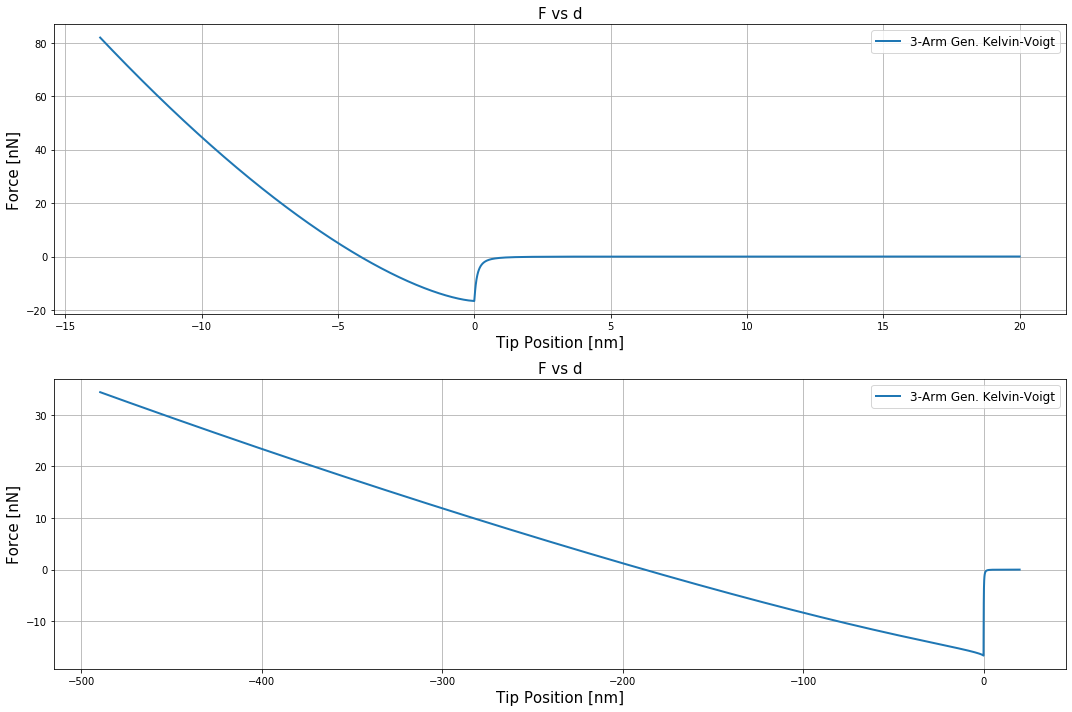

In [12]:
cmap = cm.coolwarm
colors = [cmap(0.01), cmap(0.2), cmap(0.9)]

fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)

ax[0].set_title('F vs d', fontsize=15)
ax[0].plot(tip_3[::int(1e3)]*1e9, Fts_3[::int(1e3)]*1e9, '-', lw=2, label='3-Arm Gen. Kelvin-Voigt')
ax[0].set_xlabel('Tip Position [nm]', fontsize=15)
ax[0].set_ylabel('Force [nN]', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

ax[1].set_title('F vs d', fontsize=15)
ax[1].plot(tip_5[::int(1e3)]*1e9, Fts_5[::int(1e3)]*1e9, '-', lw=2, label='3-Arm Gen. Kelvin-Voigt')
ax[1].set_xlabel('Tip Position [nm]', fontsize=15)
ax[1].set_ylabel('Force [nN]', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

plt.show()